In [1]:
import math
import shutil
from pathlib import Path

import matplotlib.pyplot as plt
import torch
from lora_module import LoraTraining
from peft import LoraConfig, TaskType, get_peft_model
from remote_module import CustomConv1D
from tqdm import tqdm
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    Conv1D,
    DataCollatorForLanguageModeling,
    TextDataset,
    Trainer,
    TrainingArguments,
)

from concrete.ml.torch.hybrid_model import HybridFHEModel

SEED = 0
torch.manual_seed(SEED)
torch.use_deterministic_algorithms(True)

model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Freeze weights
for param in model.parameters():
    param.requires_grad = False

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [2]:
def generate_text(prompt, model, tokenizer, max_new_tokens=30):
    # Encode the input prompt
    inputs = tokenizer.encode_plus(prompt, return_tensors="pt")

    # Generate text
    output = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_new_tokens=max_new_tokens,
        num_return_sequences=1,
        no_repeat_ngram_size=2,
        top_k=50,
        top_p=0.95,
        temperature=0.7,
        do_sample=True,
        pad_token_id=tokenizer.eos_token_id,
    )

    # Decode the generated text
    generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
    return generated_text

In [3]:
# Example usage
prompt = "What is FHE ?"
generated_text = generate_text(prompt, model, tokenizer)
print(generated_text)

What is FHE? FH: A basic program that is used to calculate the height of an object, and then sets the minimum height to be the object's height.


In [4]:
peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    r=4,
    lora_alpha=32,
    lora_dropout=0.05,
    fan_in_fan_out=True,
)

peft_model = get_peft_model(model, peft_config)

In [5]:
def replace_conv1d(module, module_index_to_skip=0):
    for name, child in module.named_children():
        if isinstance(child, Conv1D):

            # Skip the module if the index has not been reached, and decrement the index
            if module_index_to_skip >= 0:
                module_index_to_skip -= 1
            else:
                custom_linear = CustomConv1D(child.weight, bias=child.bias)
                setattr(module, name, custom_linear)
        else:
            module_index_to_skip = replace_conv1d(child, module_index_to_skip=module_index_to_skip)

    return module_index_to_skip


# Gradients of the first base layer that is used for fine-tuning are not needed. We
# therefore need to exclude the backward module from the remote_names since calibration
# won't get through it (which raises an issue with hybrid models)
replace_conv1d(peft_model, module_index_to_skip=0);

In [6]:
GRADIENT_ACCUMULATION_STEPS = 2

lora_training = LoraTraining(peft_model, GRADIENT_ACCUMULATION_STEPS)

In [7]:
BLOCK_SIZE = 128

train_dataset = TextDataset(
    tokenizer=tokenizer,
    file_path="data_finetune/what_is_fhe.txt",
    block_size=BLOCK_SIZE,
    cache_dir="cache_dataset",
)

In [8]:
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

EPOCHS = 100
PER_DEVICE_TRAIN_BATCH_SIZE = 4

training_args = TrainingArguments(
    output_dir="./checkpoints",
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
    save_total_limit=1,
    use_cpu=True,
    learning_rate=5e-4,
    logging_strategy="epoch",
    optim="adamw_torch",
    seed=SEED,
    data_seed=SEED,
    weight_decay=0.0,
    warmup_steps=0,
    max_grad_norm=1.0,
)

In [9]:
trainer = Trainer(
    model=peft_model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
)

train_dataloader = trainer.get_train_dataloader()

len_dataloader = len(train_dataloader)
num_update_steps_per_epoch = len_dataloader // training_args.gradient_accumulation_steps
num_update_steps_per_epoch = max(num_update_steps_per_epoch, 1)
max_steps = math.ceil(training_args.num_train_epochs * num_update_steps_per_epoch)

trainer.create_optimizer_and_scheduler(num_training_steps=max_steps)

lora_training.update_training_parameters(trainer.optimizer, trainer.lr_scheduler, training_args)

In [10]:
def get_remote_names(model):
    remote_names = []
    for name, module in model.named_modules():
        # Some gradients are not needed for fine-tuning, so need to exclude the backward module
        # from the remote_names since calibration won't get through it (which raises an issue with
        # hybrid models). We however still need to include the associated module's forward pass in
        # the hybrid model
        if isinstance(module, Conv1D):
            remote_names.append(name)

        elif isinstance(module, CustomConv1D):
            remote_names.append(name + ".forward_module")
            remote_names.append(name + ".backward_module")

    return remote_names


remote_names = get_remote_names(lora_training)

In [11]:
hybrid_model = HybridFHEModel(lora_training, module_names=remote_names)

In [12]:
input_tensor = torch.randint(0, 2, (PER_DEVICE_TRAIN_BATCH_SIZE, BLOCK_SIZE)) * (
    tokenizer.vocab_size - 1
)
label_tensor = torch.randint(0, 2, (PER_DEVICE_TRAIN_BATCH_SIZE, BLOCK_SIZE)) * (
    tokenizer.vocab_size - 1
)

inputset = (input_tensor, label_tensor)

In [13]:
hybrid_model.model.toggle_calibrate(enable=True)

hybrid_model.compile_model(
    inputset, n_bits=8, rounding_threshold_bits={"n_bits": 6, "method": "approximate"}
)

hybrid_model.model.toggle_calibrate(enable=False)

In [14]:
def train_custom_model(hybrid_model, train_dataloader, training_args, fhe="disable"):
    device = "cpu"
    hybrid_model.model.to(device)

    # Training loop
    hybrid_model.model.inference_model.train()

    total_epochs = int(training_args.num_train_epochs)
    epoch_pbar = tqdm(total=total_epochs, desc="Training Progress", position=0)

    total_batched_samples = 0
    epoch_losses = []  # List to store the loss for each epoch

    for epoch in range(total_epochs):
        total_loss = 0
        grad_norms = []

        steps_in_epoch = len(train_dataloader)
        for step, batch in enumerate(train_dataloader):
            total_batched_samples += 1

            batch = {k: v.to(device) for k, v in batch.items()}

            # Gradient accumulation
            is_last_batch_step = (
                steps_in_epoch <= training_args.gradient_accumulation_steps
                and (step + 1) == steps_in_epoch  # noqa: W503
            )
            accumulate_gradients = (
                total_batched_samples % training_args.gradient_accumulation_steps == 0
            )

            run_optimizer = is_last_batch_step or accumulate_gradients

            hybrid_model.model.toggle_run_optimizer(enable=run_optimizer)

            loss, grad_norm = hybrid_model((batch["input_ids"], batch["labels"]), fhe=fhe)

            total_loss += loss.item()

            if grad_norm is not None:
                grad_norms.append(grad_norm)

        # Get current learning rate
        current_lr = hybrid_model.model.lr_scheduler.get_last_lr()[0]

        # Get last grad norm
        current_grad_norm = grad_norms[-1]

        # Store the total loss for this epoch
        epoch_losses.append(total_loss)

        # Log epoch results
        print(
            f"Epoch {epoch + 1}/{training_args.num_train_epochs}, "
            f"Loss: {total_loss:.4f}, grad norm: {current_grad_norm}, lr: {current_lr}"
        )

        epoch_pbar.update(1)

    # Save model checkpoint
    if training_args.output_dir is not None:
        save_path = f"{training_args.output_dir}/checkpoint-{epoch + 1}"
        hybrid_model.model.inference_model.save_pretrained(save_path)

    epoch_pbar.close()

    # Plot the loss evolution
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, total_epochs + 1), epoch_losses, marker="o")
    plt.title("Loss Evolution During Training")
    plt.xlabel("Epoch")
    plt.ylabel("Total Loss")
    plt.grid(True)
    plt.show()

Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]

Training Progress:   1%|          | 1/100 [00:01<02:11,  1.32s/it]

Epoch 1/100, Loss: 1.5258, grad norm: 0.5043994784355164, lr: 0.000495


Training Progress:   2%|▏         | 2/100 [00:01<01:16,  1.28it/s]

Epoch 2/100, Loss: 1.4975, grad norm: 0.49957117438316345, lr: 0.00049


Training Progress:   3%|▎         | 3/100 [00:02<00:58,  1.66it/s]

Epoch 3/100, Loss: 1.4868, grad norm: 0.4209097921848297, lr: 0.00048499999999999997


Training Progress:   4%|▍         | 4/100 [00:02<00:50,  1.91it/s]

Epoch 4/100, Loss: 1.4791, grad norm: 0.494621604681015, lr: 0.00048


Training Progress:   5%|▌         | 5/100 [00:02<00:44,  2.13it/s]

Epoch 5/100, Loss: 1.4361, grad norm: 0.4343641698360443, lr: 0.000475


Training Progress:   6%|▌         | 6/100 [00:03<00:40,  2.29it/s]

Epoch 6/100, Loss: 1.4400, grad norm: 0.489236056804657, lr: 0.00047


Training Progress:   7%|▋         | 7/100 [00:03<00:37,  2.45it/s]

Epoch 7/100, Loss: 1.4170, grad norm: 0.5628056526184082, lr: 0.000465


Training Progress:   8%|▊         | 8/100 [00:03<00:35,  2.56it/s]

Epoch 8/100, Loss: 1.3922, grad norm: 0.4798496663570404, lr: 0.00046


Training Progress:   9%|▉         | 9/100 [00:04<00:33,  2.71it/s]

Epoch 9/100, Loss: 1.3769, grad norm: 0.5302374958992004, lr: 0.000455


Training Progress:  10%|█         | 10/100 [00:04<00:32,  2.81it/s]

Epoch 10/100, Loss: 1.3705, grad norm: 0.4688620865345001, lr: 0.00045000000000000004


Training Progress:  11%|█         | 11/100 [00:04<00:30,  2.88it/s]

Epoch 11/100, Loss: 1.3480, grad norm: 0.4672289490699768, lr: 0.00044500000000000003


Training Progress:  12%|█▏        | 12/100 [00:05<00:29,  2.94it/s]

Epoch 12/100, Loss: 1.3207, grad norm: 0.588039219379425, lr: 0.00044


Training Progress:  13%|█▎        | 13/100 [00:05<00:29,  2.97it/s]

Epoch 13/100, Loss: 1.2922, grad norm: 0.5210426449775696, lr: 0.000435


Training Progress:  14%|█▍        | 14/100 [00:05<00:28,  2.97it/s]

Epoch 14/100, Loss: 1.2897, grad norm: 0.47131291031837463, lr: 0.00043


Training Progress:  15%|█▌        | 15/100 [00:06<00:28,  2.99it/s]

Epoch 15/100, Loss: 1.2512, grad norm: 0.660230815410614, lr: 0.000425


Training Progress:  16%|█▌        | 16/100 [00:06<00:28,  2.95it/s]

Epoch 16/100, Loss: 1.2728, grad norm: 0.5080279111862183, lr: 0.00042


Training Progress:  17%|█▋        | 17/100 [00:07<00:30,  2.71it/s]

Epoch 17/100, Loss: 1.2300, grad norm: 0.6563513875007629, lr: 0.000415


Training Progress:  18%|█▊        | 18/100 [00:07<00:30,  2.67it/s]

Epoch 18/100, Loss: 1.2194, grad norm: 0.624626100063324, lr: 0.00041


Training Progress:  19%|█▉        | 19/100 [00:07<00:29,  2.72it/s]

Epoch 19/100, Loss: 1.2062, grad norm: 1.0465713739395142, lr: 0.00040500000000000003


Training Progress:  20%|██        | 20/100 [00:08<00:28,  2.82it/s]

Epoch 20/100, Loss: 1.1679, grad norm: 0.6334244608879089, lr: 0.0004


Training Progress:  21%|██        | 21/100 [00:08<00:27,  2.89it/s]

Epoch 21/100, Loss: 1.1653, grad norm: 0.7065843939781189, lr: 0.000395


Training Progress:  22%|██▏       | 22/100 [00:08<00:26,  2.94it/s]

Epoch 22/100, Loss: 1.1242, grad norm: 0.5430387854576111, lr: 0.00039000000000000005


Training Progress:  23%|██▎       | 23/100 [00:09<00:25,  2.97it/s]

Epoch 23/100, Loss: 1.1281, grad norm: 0.8001676201820374, lr: 0.00038500000000000003


Training Progress:  24%|██▍       | 24/100 [00:09<00:25,  2.99it/s]

Epoch 24/100, Loss: 1.1169, grad norm: 0.5735489726066589, lr: 0.00038


Training Progress:  25%|██▌       | 25/100 [00:09<00:24,  3.02it/s]

Epoch 25/100, Loss: 1.1163, grad norm: 0.644894540309906, lr: 0.000375


Training Progress:  26%|██▌       | 26/100 [00:10<00:24,  3.03it/s]

Epoch 26/100, Loss: 1.0545, grad norm: 0.5457342863082886, lr: 0.00037


Training Progress:  27%|██▋       | 27/100 [00:10<00:24,  3.03it/s]

Epoch 27/100, Loss: 1.0625, grad norm: 0.5880767703056335, lr: 0.000365


Training Progress:  28%|██▊       | 28/100 [00:10<00:23,  3.02it/s]

Epoch 28/100, Loss: 1.0756, grad norm: 0.7266576290130615, lr: 0.00035999999999999997


Training Progress:  29%|██▉       | 29/100 [00:11<00:27,  2.59it/s]

Epoch 29/100, Loss: 1.0279, grad norm: 0.761441707611084, lr: 0.000355


Training Progress:  30%|███       | 30/100 [00:11<00:25,  2.72it/s]

Epoch 30/100, Loss: 1.0476, grad norm: 0.5998173356056213, lr: 0.00035


Training Progress:  31%|███       | 31/100 [00:11<00:24,  2.81it/s]

Epoch 31/100, Loss: 0.9871, grad norm: 0.6272050142288208, lr: 0.000345


Training Progress:  32%|███▏      | 32/100 [00:12<00:23,  2.87it/s]

Epoch 32/100, Loss: 0.9927, grad norm: 0.696142315864563, lr: 0.00034


Training Progress:  33%|███▎      | 33/100 [00:12<00:22,  2.91it/s]

Epoch 33/100, Loss: 0.9811, grad norm: 0.677040696144104, lr: 0.000335


Training Progress:  34%|███▍      | 34/100 [00:12<00:22,  2.96it/s]

Epoch 34/100, Loss: 0.9478, grad norm: 0.5834782123565674, lr: 0.00033


Training Progress:  35%|███▌      | 35/100 [00:13<00:21,  2.98it/s]

Epoch 35/100, Loss: 0.9502, grad norm: 0.7100946307182312, lr: 0.00032500000000000004


Training Progress:  36%|███▌      | 36/100 [00:13<00:21,  2.99it/s]

Epoch 36/100, Loss: 0.9314, grad norm: 0.6227987408638, lr: 0.00032


Training Progress:  37%|███▋      | 37/100 [00:13<00:20,  3.00it/s]

Epoch 37/100, Loss: 0.9117, grad norm: 0.6908254623413086, lr: 0.000315


Training Progress:  38%|███▊      | 38/100 [00:14<00:20,  3.01it/s]

Epoch 38/100, Loss: 0.9086, grad norm: 0.6995803117752075, lr: 0.00031


Training Progress:  39%|███▉      | 39/100 [00:14<00:20,  3.01it/s]

Epoch 39/100, Loss: 0.8922, grad norm: 0.6593760251998901, lr: 0.000305


Training Progress:  40%|████      | 40/100 [00:14<00:19,  3.02it/s]

Epoch 40/100, Loss: 0.8877, grad norm: 0.8770199418067932, lr: 0.0003


Training Progress:  41%|████      | 41/100 [00:15<00:19,  3.01it/s]

Epoch 41/100, Loss: 0.8585, grad norm: 0.7341364026069641, lr: 0.000295


Training Progress:  42%|████▏     | 42/100 [00:15<00:19,  3.03it/s]

Epoch 42/100, Loss: 0.8350, grad norm: 0.7358282208442688, lr: 0.00029


Training Progress:  43%|████▎     | 43/100 [00:15<00:18,  3.03it/s]

Epoch 43/100, Loss: 0.8387, grad norm: 0.7404325604438782, lr: 0.000285


Training Progress:  44%|████▍     | 44/100 [00:16<00:18,  3.07it/s]

Epoch 44/100, Loss: 0.8309, grad norm: 0.6944113373756409, lr: 0.00028000000000000003


Training Progress:  45%|████▌     | 45/100 [00:16<00:17,  3.07it/s]

Epoch 45/100, Loss: 0.8247, grad norm: 0.7996678352355957, lr: 0.000275


Training Progress:  46%|████▌     | 46/100 [00:16<00:17,  3.07it/s]

Epoch 46/100, Loss: 0.8105, grad norm: 0.8883722424507141, lr: 0.00027


Training Progress:  47%|████▋     | 47/100 [00:17<00:17,  3.07it/s]

Epoch 47/100, Loss: 0.8115, grad norm: 0.966903805732727, lr: 0.00026500000000000004


Training Progress:  48%|████▊     | 48/100 [00:17<00:17,  3.05it/s]

Epoch 48/100, Loss: 0.7966, grad norm: 0.9066370725631714, lr: 0.00026000000000000003


Training Progress:  49%|████▉     | 49/100 [00:17<00:16,  3.06it/s]

Epoch 49/100, Loss: 0.8019, grad norm: 0.8817624449729919, lr: 0.000255


Training Progress:  50%|█████     | 50/100 [00:18<00:16,  3.06it/s]

Epoch 50/100, Loss: 0.7533, grad norm: 1.3840082883834839, lr: 0.00025


Training Progress:  51%|█████     | 51/100 [00:18<00:15,  3.18it/s]

Epoch 51/100, Loss: 0.7568, grad norm: 0.8748838901519775, lr: 0.000245


Training Progress:  52%|█████▏    | 52/100 [00:18<00:15,  3.15it/s]

Epoch 52/100, Loss: 0.7385, grad norm: 0.7864347696304321, lr: 0.00024


Training Progress:  53%|█████▎    | 53/100 [00:19<00:15,  3.11it/s]

Epoch 53/100, Loss: 0.7399, grad norm: 1.041102647781372, lr: 0.000235


Training Progress:  54%|█████▍    | 54/100 [00:19<00:14,  3.09it/s]

Epoch 54/100, Loss: 0.7320, grad norm: 0.9289358854293823, lr: 0.00023


Training Progress:  55%|█████▌    | 55/100 [00:19<00:14,  3.08it/s]

Epoch 55/100, Loss: 0.7254, grad norm: 1.0431201457977295, lr: 0.00022500000000000002


Training Progress:  56%|█████▌    | 56/100 [00:20<00:14,  3.04it/s]

Epoch 56/100, Loss: 0.7216, grad norm: 0.9567640423774719, lr: 0.00022


Training Progress:  57%|█████▋    | 57/100 [00:20<00:14,  3.04it/s]

Epoch 57/100, Loss: 0.6991, grad norm: 1.0234575271606445, lr: 0.000215


Training Progress:  58%|█████▊    | 58/100 [00:20<00:13,  3.04it/s]

Epoch 58/100, Loss: 0.6988, grad norm: 0.8934121131896973, lr: 0.00021


Training Progress:  59%|█████▉    | 59/100 [00:21<00:13,  3.03it/s]

Epoch 59/100, Loss: 0.6933, grad norm: 0.8631471395492554, lr: 0.000205


Training Progress:  60%|██████    | 60/100 [00:21<00:13,  3.01it/s]

Epoch 60/100, Loss: 0.6737, grad norm: 0.9076031446456909, lr: 0.0002


Training Progress:  61%|██████    | 61/100 [00:21<00:12,  3.01it/s]

Epoch 61/100, Loss: 0.6731, grad norm: 0.958336591720581, lr: 0.00019500000000000002


Training Progress:  62%|██████▏   | 62/100 [00:22<00:12,  3.00it/s]

Epoch 62/100, Loss: 0.6511, grad norm: 0.871760368347168, lr: 0.00019


Training Progress:  63%|██████▎   | 63/100 [00:22<00:12,  3.01it/s]

Epoch 63/100, Loss: 0.6524, grad norm: 0.9131544232368469, lr: 0.000185


Training Progress:  64%|██████▍   | 64/100 [00:22<00:11,  3.01it/s]

Epoch 64/100, Loss: 0.6392, grad norm: 1.0097497701644897, lr: 0.00017999999999999998


Training Progress:  65%|██████▌   | 65/100 [00:23<00:11,  3.01it/s]

Epoch 65/100, Loss: 0.6467, grad norm: 0.9693806171417236, lr: 0.000175


Training Progress:  66%|██████▌   | 66/100 [00:23<00:11,  3.01it/s]

Epoch 66/100, Loss: 0.6262, grad norm: 0.9055477380752563, lr: 0.00017


Training Progress:  67%|██████▋   | 67/100 [00:23<00:11,  3.00it/s]

Epoch 67/100, Loss: 0.6222, grad norm: 1.1049680709838867, lr: 0.000165


Training Progress:  68%|██████▊   | 68/100 [00:24<00:10,  2.99it/s]

Epoch 68/100, Loss: 0.6138, grad norm: 1.0114023685455322, lr: 0.00016


Training Progress:  69%|██████▉   | 69/100 [00:24<00:10,  3.00it/s]

Epoch 69/100, Loss: 0.6125, grad norm: 1.0613059997558594, lr: 0.000155


Training Progress:  70%|███████   | 70/100 [00:24<00:09,  3.00it/s]

Epoch 70/100, Loss: 0.6049, grad norm: 0.957007110118866, lr: 0.00015


Training Progress:  71%|███████   | 71/100 [00:25<00:09,  2.99it/s]

Epoch 71/100, Loss: 0.6210, grad norm: 1.1933284997940063, lr: 0.000145


Training Progress:  72%|███████▏  | 72/100 [00:25<00:09,  2.99it/s]

Epoch 72/100, Loss: 0.6144, grad norm: 1.0894461870193481, lr: 0.00014000000000000001


Training Progress:  73%|███████▎  | 73/100 [00:25<00:09,  3.00it/s]

Epoch 73/100, Loss: 0.5742, grad norm: 1.049686312675476, lr: 0.000135


Training Progress:  74%|███████▍  | 74/100 [00:26<00:08,  3.00it/s]

Epoch 74/100, Loss: 0.6121, grad norm: 1.2899885177612305, lr: 0.00013000000000000002


Training Progress:  75%|███████▌  | 75/100 [00:26<00:08,  3.00it/s]

Epoch 75/100, Loss: 0.5839, grad norm: 1.0688285827636719, lr: 0.000125


Training Progress:  76%|███████▌  | 76/100 [00:26<00:07,  3.01it/s]

Epoch 76/100, Loss: 0.6207, grad norm: 1.1526310443878174, lr: 0.00012


Training Progress:  77%|███████▋  | 77/100 [00:27<00:07,  3.01it/s]

Epoch 77/100, Loss: 0.5837, grad norm: 1.1352548599243164, lr: 0.000115


Training Progress:  78%|███████▊  | 78/100 [00:27<00:07,  3.01it/s]

Epoch 78/100, Loss: 0.5777, grad norm: 1.082857370376587, lr: 0.00011


Training Progress:  79%|███████▉  | 79/100 [00:27<00:06,  3.02it/s]

Epoch 79/100, Loss: 0.5608, grad norm: 1.0222446918487549, lr: 0.000105


Training Progress:  80%|████████  | 80/100 [00:28<00:06,  3.01it/s]

Epoch 80/100, Loss: 0.5821, grad norm: 1.1967228651046753, lr: 0.0001


Training Progress:  81%|████████  | 81/100 [00:28<00:06,  3.01it/s]

Epoch 81/100, Loss: 0.5663, grad norm: 0.9704416394233704, lr: 9.5e-05


Training Progress:  82%|████████▏ | 82/100 [00:28<00:05,  3.01it/s]

Epoch 82/100, Loss: 0.5708, grad norm: 1.2309505939483643, lr: 8.999999999999999e-05


Training Progress:  83%|████████▎ | 83/100 [00:29<00:05,  3.01it/s]

Epoch 83/100, Loss: 0.5340, grad norm: 0.9654510021209717, lr: 8.5e-05


Training Progress:  84%|████████▍ | 84/100 [00:29<00:05,  3.00it/s]

Epoch 84/100, Loss: 0.5381, grad norm: 1.011785626411438, lr: 8e-05


Training Progress:  85%|████████▌ | 85/100 [00:29<00:05,  3.00it/s]

Epoch 85/100, Loss: 0.5161, grad norm: 1.063707947731018, lr: 7.5e-05


Training Progress:  86%|████████▌ | 86/100 [00:30<00:04,  3.02it/s]

Epoch 86/100, Loss: 0.5731, grad norm: 1.1859869956970215, lr: 7.000000000000001e-05


Training Progress:  87%|████████▋ | 87/100 [00:30<00:04,  3.02it/s]

Epoch 87/100, Loss: 0.5630, grad norm: 1.3685344457626343, lr: 6.500000000000001e-05


Training Progress:  88%|████████▊ | 88/100 [00:30<00:03,  3.02it/s]

Epoch 88/100, Loss: 0.5499, grad norm: 1.1439831256866455, lr: 6e-05


Training Progress:  89%|████████▉ | 89/100 [00:31<00:03,  3.02it/s]

Epoch 89/100, Loss: 0.5343, grad norm: 1.0189402103424072, lr: 5.5e-05


Training Progress:  90%|█████████ | 90/100 [00:31<00:03,  3.00it/s]

Epoch 90/100, Loss: 0.5162, grad norm: 1.0636950731277466, lr: 5e-05


Training Progress:  91%|█████████ | 91/100 [00:31<00:02,  3.01it/s]

Epoch 91/100, Loss: 0.5320, grad norm: 1.0511903762817383, lr: 4.4999999999999996e-05


Training Progress:  92%|█████████▏| 92/100 [00:32<00:02,  3.03it/s]

Epoch 92/100, Loss: 0.5255, grad norm: 0.980833888053894, lr: 4e-05


Training Progress:  93%|█████████▎| 93/100 [00:32<00:02,  3.02it/s]

Epoch 93/100, Loss: 0.5311, grad norm: 0.9822009801864624, lr: 3.5000000000000004e-05


Training Progress:  94%|█████████▍| 94/100 [00:32<00:01,  3.02it/s]

Epoch 94/100, Loss: 0.5263, grad norm: 1.096509575843811, lr: 3e-05


Training Progress:  95%|█████████▌| 95/100 [00:33<00:01,  3.02it/s]

Epoch 95/100, Loss: 0.5351, grad norm: 1.1128621101379395, lr: 2.5e-05


Training Progress:  96%|█████████▌| 96/100 [00:33<00:01,  3.02it/s]

Epoch 96/100, Loss: 0.5507, grad norm: 1.103196382522583, lr: 2e-05


Training Progress:  97%|█████████▋| 97/100 [00:33<00:00,  3.01it/s]

Epoch 97/100, Loss: 0.5164, grad norm: 1.0258852243423462, lr: 1.5e-05


Training Progress:  98%|█████████▊| 98/100 [00:34<00:00,  2.93it/s]

Epoch 98/100, Loss: 0.5119, grad norm: 1.0328097343444824, lr: 1e-05


Training Progress:  99%|█████████▉| 99/100 [00:34<00:00,  2.85it/s]

Epoch 99/100, Loss: 0.5271, grad norm: 1.056510090827942, lr: 5e-06


Training Progress: 100%|██████████| 100/100 [00:34<00:00,  2.80it/s]

Epoch 100/100, Loss: 0.5508, grad norm: 1.031651496887207, lr: 0.0


Training Progress: 100%|██████████| 100/100 [00:35<00:00,  2.85it/s]

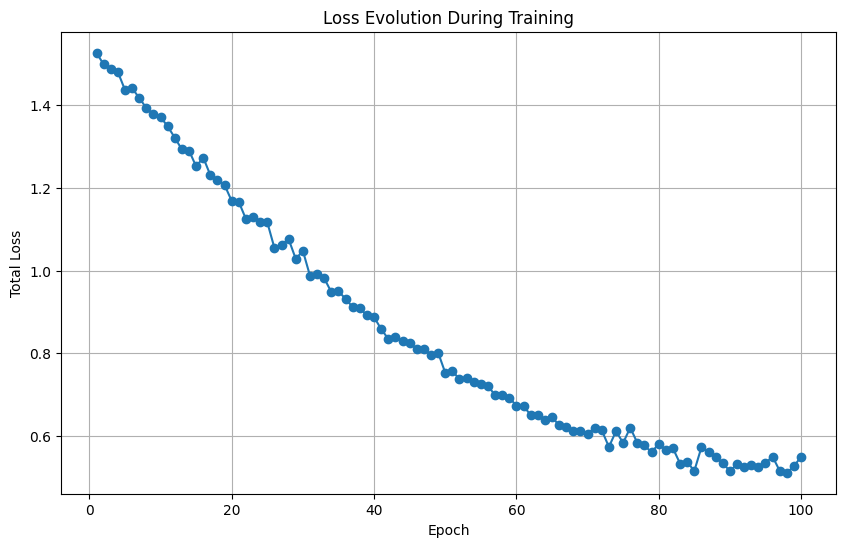

In [15]:
train_custom_model(hybrid_model, train_dataloader, training_args, fhe="disable")

In [16]:
fine_tuned_model = hybrid_model.model.inference_model

# In simulation, we can only generate a single token at a time because of fixed size circuits
# and how `generate` works (only the last token from the previous generation is kept)
hybrid_model.set_fhe_mode("disable")

In [17]:
prompt = "What is FHE ?"
generated_text = generate_text(prompt, fine_tuned_model, tokenizer)
print(generated_text)

What is FHE?

The FSH paradigm is the concept that allows the computation of arbitrary values to an external processor. This technique is useful for many different purposes,


In [18]:
peft_model.disable_adapter_layers()

prompt = "What is FHE ?"
generated_text = generate_text(prompt, fine_tuned_model, tokenizer)
print(generated_text)

peft_model.enable_adapter_layers()

What is FHE?

FHE is a single-layer, multi-direction, and multi. It is designed to be an efficient, single directional, inter-


In [19]:
def print_weights_and_size(model, print_detail=False):
    total_weights = 0
    total_lora_weights = 0
    for name, param in model.named_parameters():
        total_weights += param.numel()

        if "lora" in name:
            total_lora_weights += param.numel()

        if print_detail:
            print(name, param.numel())

    print(f"Total number of weights: {total_weights}")
    print(f"Total number of LoRA weights: {total_lora_weights}")

    return total_weights

In [20]:
total_weights_size = print_weights_and_size(hybrid_model.model)

Total number of weights: 124587264
Total number of LoRA weights: 147456


In [21]:
path = Path("gpt2_lora_finetuned_hybrid_deployment")

if path.is_dir() and any(path.iterdir()):
    shutil.rmtree(path)

hybrid_model.save_and_clear_private_info(path)

In [22]:
total_weights_size_private = print_weights_and_size(hybrid_model.model)

Total number of weights: 39569664
Total number of LoRA weights: 147456


In [23]:
print(
    "Total weights removed: "
    f"{(total_weights_size - total_weights_size_private) / total_weights_size * 100:.2f} %"
)

Total weights removed: 68.24 %
